<a href="https://colab.research.google.com/github/floflokie/SSL/blob/main/TP_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
%%capture
!pip install -U fashion-clip

In [33]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [34]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [35]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# upprimer les images dont la catégrie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [36]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [37]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
batch_size = 32
image_embeddings = fclip.encode_images(images, batch_size=batch_size)
text_embeddings = fclip.encode_text(texts, batch_size=batch_size)


 90%|████████▉ | 2780/3104 [17:33<02:02,  2.64it/s] 


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:05<00:00, 16.73it/s]


In [38]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

100%|██████████| 1/1 [00:00<00:00, 53.25it/s]


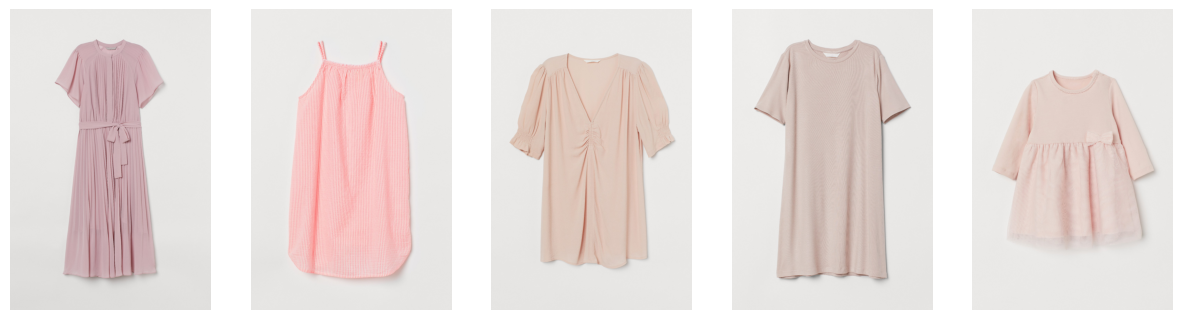

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
def search_engine(query, top=5):
  query_embedding = fclip.encode_text([query], batch_size=1)
  sim = cosine_similarity(query_embedding, image_embeddings)
  # get top 5
  top_images = np.argsort(sim[0])[-top:][::-1]
  return top_images

# query : a pink dress
dresses = search_engine("a pink dress")
plt.figure(figsize=(15,15))
for i, idx in enumerate(dresses):
  plt.subplot(1,5,i+1)
  plt.imshow(Image.open(images[idx]))
  plt.axis("off")


Notre moteur de recherche semble bien fonctionner.

# Classification zero-shot

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



On utilisera les types de produit comme labels.

In [40]:
labels = subset["product_type_name"].tolist()


In [42]:
model = LogisticRegression(max_iter=1000)
train_images, test_images, train_labels, test_labels = train_test_split(image_embeddings, labels, test_size=0.2, random_state=42)
model.fit(train_images, train_labels)

# test accuracy
y_pred = model.predict(test_images)
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(test_labels, y_pred))

Accuracy: 0.7729468599033816
                   precision    recall  f1-score   support

              Bag       0.78      0.88      0.82         8
       Ballerinas       1.00      0.50      0.67         4
             Belt       0.75      1.00      0.86         3
       Bikini top       0.88      0.78      0.82         9
           Blazer       0.88      0.88      0.88         8
           Blouse       0.60      0.67      0.63        18
         Bodysuit       0.83      0.83      0.83         6
            Boots       0.80      0.67      0.73         6
              Bra       1.00      1.00      1.00         7
       Cap/peaked       0.80      1.00      0.89         4
         Cardigan       0.80      1.00      0.89         4
             Coat       1.00      1.00      1.00         2
            Dress       0.81      0.85      0.83        66
        Dungarees       0.00      0.00      0.00         3
          Earring       1.00      0.87      0.93        15
      Garment Set       0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

On obtient de très bon résultats. On a un score de 0 sur top mais c'est un mot peu précis.

Ci-dessous une démonstration du classifier.